In [1]:
import datetime as dt
from sklearn.metrics import r2_score
from Data import Data
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as pyplot 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from pandas import read_csv
from GoogleTrendAPI_Direct import GoogleTrendAPI

# choose the time range of data:
start_date, end_date = dt.datetime.today() - dt.timedelta(days=120), dt.datetime.today()
data = Data()


Bad key "text.kerning_factor" on line 4 in
C:\Users\alexm\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


data/finance_data.csv finance data file exists and will be loaded
data/google_trend_data.csv : Google trend data file exist and will be loaded


In [2]:
# load the data where BTC-USD is bitcoin price in usd and "bitcoin" column indicates google trend hits
full_data = data.gather_data(start_date, end_date)
full_data.head()

loading additional data from  2022-01-11 00:00:00 to,  2022-01-16 15:20:32.773313
overlap 2022-01-11T00:00:00.000000000
loading additional data from  2022-01-14 to,  2022-01-16


,Date,^GSPC,^VIX,Volume,BTC-USD,bitcoin
0,2021-10-06,4363.549805,21.000000,4.903473e+10,55361.449219,67.0
1,2021-10-07,4399.759766,19.540001,3.680786e+10,53805.984375,62.0
2,2021-10-08,4391.339844,18.770000,3.480087e+10,53967.847656,52.0
3,2021-10-09,4391.339844,18.770000,3.249121e+10,54968.222656,47.0
4,2021-10-10,4391.339844,18.770000,3.952779e+10,54771.578125,48.0


In [3]:
# load the google trend data for keyword Blockchain from the api
google_trend_api = GoogleTrendAPI("Blockchain")
google_trend_blockchain = google_trend_api.get_data(start_date, end_date)

Blockchain
overlap 2021-09-18T00:00:00.000000000
start:  2021-09-18 15:20:32.773313 end:  2021-10-18 15:20:32.773313
overlap 2021-10-18T00:00:00.000000000
start:  2021-10-18 15:20:32.773313 end:  2021-11-17 15:20:32.773313
overlap 2021-11-17T00:00:00.000000000
start:  2021-11-17 15:20:32.773313 end:  2021-12-17 15:20:32.773313
overlap 2021-12-17T00:00:00.000000000


In [4]:
# load the google trend data for keyword Cryptocurrency from the api
google_trend_crypto = GoogleTrendAPI("Cryptocurrency")
google_trend_crypto = google_trend_crypto.get_data(start_date, end_date)


Cryptocurrency
overlap 2021-09-18T00:00:00.000000000
start:  2021-09-18 15:20:32.773313 end:  2021-10-18 15:20:32.773313
overlap 2021-10-18T00:00:00.000000000
start:  2021-10-18 15:20:32.773313 end:  2021-11-17 15:20:32.773313
overlap 2021-11-17T00:00:00.000000000
start:  2021-11-17 15:20:32.773313 end:  2021-12-17 15:20:32.773313
overlap 2021-12-17T00:00:00.000000000


In [5]:
final_data = full_data.merge(google_trend_crypto, on=['Date'])
final_data = final_data.merge(google_trend_blockchain, on=['Date'])

In [6]:
final_data["output"] = final_data["BTC-USD"]
del final_data["BTC-USD"]

In [7]:
final_data

,Date,^GSPC,^VIX,Volume,bitcoin,Cryptocurrency,Blockchain,output
0,2021-10-06,4363.549805,21.000000,4.903473e+10,67.000000,80.000000,89.000000,55361.449219
1,2021-10-07,4399.759766,19.540001,3.680786e+10,62.000000,100.000000,92.000000,53805.984375
2,2021-10-08,4391.339844,18.770000,3.480087e+10,52.000000,79.000000,83.000000,53967.847656
3,2021-10-09,4391.339844,18.770000,3.249121e+10,47.000000,76.000000,64.000000,54968.222656
4,2021-10-10,4391.339844,18.770000,3.952779e+10,48.000000,69.000000,71.000000,54771.578125
...,...,...,...,...,...,...,...,...
96,2022-01-10,4670.290039,19.400000,3.210423e+10,61.109278,61.905499,82.378472,41821.261719
97,2022-01-11,4713.069824,18.410000,2.632765e+10,54.787629,62.857891,82.378472,42735.855469
98,2022-01-12,4726.350098,17.620001,3.349994e+10,53.691876,57.143538,89.006625,43949.101562
99,2022-01-13,4659.029785,20.309999,3.349994e+10,52.596124,60.000715,80.484714,43949.101562


In [8]:
final_data = final_data.set_index("Date")
values = final_data.values

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Here is created input columns which are (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Here is created output/forecast column which are (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# here checked values numeric format 
values = values.astype('float32')


In [10]:
# Dataset values are normalized by using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
#print(scaled)

# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028929   0.371819   0.460426   0.409722   0.119680   0.708264   
2   0.110134   0.281192   0.272799   0.335317   0.198222   0.760945   
3   0.091251   0.233395   0.242001   0.186508   0.115753   0.602902   
4   0.091251   0.233395   0.206558   0.112103   0.103972   0.269257   
5   0.091251   0.233395   0.314538   0.126984   0.076482   0.392179   

   var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.530723  0.110134  0.281192  0.272799  0.335317  0.198222  0.760945   
2   0.470918  0.091251  0.233395  0.242001  0.186508  0.115753  0.602902   
3   0.477142  0.091251  0.233395  0.206558  0.112103  0.103972  0.269257   
4   0.515605  0.091251  0.233395  0.314538  0.126984  0.076482  0.392179   
5   0.508044  0.023637  0.309745  0.362255  0.275794  0.088263  0.515101   

    var7(t)  
1  0.470918  
2  0.477142  
3  0.515605  
4  0.508044  
5  0.612362  


In [11]:
values = reframed.values 
train_size = int(len(values)*0.70)
train = values[:train_size,:]
test = values[train_size:,:]

# Splitted datasets are splitted to trainX, trainY, testX and testY 
trainX, trainY = train[:,:-1], train[:,-1]
testX, testY = test[:,:-1], test[:,-1]
print(trainY, trainY.shape)

[0.4709183  0.47714174 0.5156046  0.5080439  0.61236227 0.5568534
 0.60914457 0.60608494 0.7703527  0.7433709  0.76880205 0.7869674
 0.87293446 0.93948257 0.79404557 0.7356845  0.7626504  0.7448572
 0.8259443  0.72305524 0.65071833 0.73298824 0.7947296  0.7816905
 0.7597798  0.7476858  0.83311784 0.8232614  0.7649039  0.7523483
 0.7677971  0.83698523 1.0000001  0.97712314 0.90112627 0.8993858
 0.868857   0.88091385 0.91925895 0.84586227 0.7152678  0.72321737
 0.59149826 0.63676894 0.6974257  0.660257   0.5663973  0.61560285
 0.5660566  0.6042839  0.46183622 0.5097164  0.60327566 0.62473404
 0.59393156 0.60255945 0.57364595 0.46293128 0.29385304 0.30031788
 0.34698558 0.35150182 0.3439932  0.23508155 0.21859431 0.3000741
 0.32836545 0.19914615 0.19434595 0.2821654 ] (70,)


In [12]:
# Train and Test datasets are reshaped in 3D size to be used in LSTM
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))
print(trainX.shape, trainY.shape,testX.shape,testY.shape)

# LSTM model is created and adjusted neuron structure
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')
# Dataset is trained by using trainX and trainY
history = model.fit(trainX, trainY, epochs=10, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

(70, 1, 13) (70,) (30, 1, 13) (30,)
Epoch 1/10
3/3 - 3s - loss: 0.5735 - val_loss: 0.1253 - 3s/epoch - 1s/step
Epoch 2/10
3/3 - 0s - loss: 0.4984 - val_loss: 0.1035 - 40ms/epoch - 13ms/step
Epoch 3/10
3/3 - 0s - loss: 0.4280 - val_loss: 0.1048 - 38ms/epoch - 13ms/step
Epoch 4/10
3/3 - 0s - loss: 0.3661 - val_loss: 0.1333 - 38ms/epoch - 13ms/step
Epoch 5/10
3/3 - 0s - loss: 0.3144 - val_loss: 0.1746 - 41ms/epoch - 14ms/step
Epoch 6/10
3/3 - 0s - loss: 0.2695 - val_loss: 0.2253 - 37ms/epoch - 12ms/step
Epoch 7/10
3/3 - 0s - loss: 0.2303 - val_loss: 0.2785 - 39ms/epoch - 13ms/step
Epoch 8/10
3/3 - 0s - loss: 0.2040 - val_loss: 0.3253 - 37ms/epoch - 12ms/step
Epoch 9/10
3/3 - 0s - loss: 0.1887 - val_loss: 0.3611 - 38ms/epoch - 13ms/step
Epoch 10/10
3/3 - 0s - loss: 0.1845 - val_loss: 0.3852 - 68ms/epoch - 23ms/step


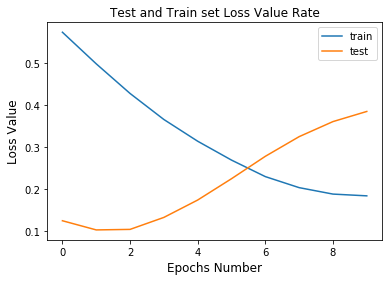

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Test and Train set Loss Value Rate")
plt.xlabel('Epochs Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.show()

In [14]:
# Prediction process is performed for train dataset
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))
print(trainX.shape)

# Prediction process is performed for test dataset
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)

(70, 13)
(30, 13)


In [15]:
# Trains dataset inverts scaling for training
train_predict_org = trainPredict
test_predict_org = testPredict
trainPredict = concatenate((trainPredict, trainX[:, -6:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]

# Test dataset inverts scaling for forecasting
testPredict = concatenate((testPredict, testX[:, -6:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]

# invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#print('actual: ', len(inv_y))

In [16]:
# Performance measure calculated by using mean_squared_error for train and test prediction
rmse2 = sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.3f' % rmse2)
rmse = sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.3f' % rmse)

Train RMSE: 4656.218
Test RMSE: 4604.571


In [17]:
r2_score(testY, testPredict)

-1735977241.6866295

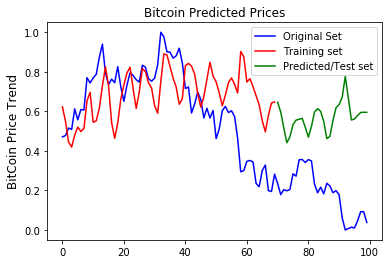

In [18]:
output = np.append(train_predict_org, test_predict_org)
#print(len(son))

final = pd.DataFrame(data=output, columns=['BTC_USD'])
actual = final_data.output
actual = values[:,-1]
actual = pd.DataFrame(data=actual, columns=['BTC_USD'])

# Finally training and prediction result are visualized
pyplot.plot(actual.BTC_USD, 'b', label='Original Set')
pyplot.plot(final.BTC_USD[0:train_size], 'r' , label='Training set')
pyplot.plot(final.BTC_USD[train_size:], 'g' , label='Predicted/Test set')
pyplot.title("Bitcoin Predicted Prices")
pyplot.ylabel('BitCoin Price Trend', fontsize=12)
pyplot.legend(loc='best')
pyplot.show()

In [19]:
history

In [20]:
gt_historyhistory.history

{'loss': [0.5735139846801758,
  0.4984206557273865,
  0.42797771096229553,
  0.3660641312599182,
  0.3143905699253082,
  0.2695302963256836,
  0.23026880621910095,
  0.2040468007326126,
  0.18872497975826263,
  0.1845458447933197],
 'val_loss': [0.12534792721271515,
  0.1035451665520668,
  0.10479146987199783,
  0.13327547907829285,
  0.1746085286140442,
  0.22529058158397675,
  0.27853867411613464,
  0.32530516386032104,
  0.36109229922294617,
  0.38519343733787537]}

In [32]:
#Write data to csv for future use

actual.to_csv("data/gt_actual.csv", index = False)
final.to_csv("data/gt_final.csv", index = False)
history_df = pd.DataFrame(history.history)
history_df.to_csv("data/gt_history.csv", index = False)